In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
import pandas as pd
import re
import json

DOMAIN = "https://letterboxd.com"

def transform_ratings(rating_text):
    # Replace with actual transformation logic if necessary
    return rating_text

def extract_rating_value(script_content):
    # Search for the ratingValue within the script content
    match = re.search(r'"ratingValue":\s*(\d+\.\d+)', script_content)
    return match.group(1) if match else None

def scrape_films(username, genre):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    movies_dict = {'id': [], 'title': [], 'rating': [], 'liked': [], 'link': [], 'year': [], 'avg_rating': []}
    url = f"{DOMAIN}/{username}/films/genre/{genre}/"
    url_page = requests.get(url, headers=headers)
    
    if url_page.status_code != 200:
        print(f"Failed to access URL: {url}")
        return pd.DataFrame()

    soup = BeautifulSoup(url_page.content, 'html.parser')
    li_pagination = soup.findAll("li", {"class": "paginate-page"})
    num_pages = int(li_pagination[-1].find('a').get_text().strip()) if li_pagination else 1

    for i in range(1, num_pages + 1):
        page_url = f"{url}page/{i}/" if li_pagination else url
        page_response = requests.get(page_url, headers=headers)
        page_soup = BeautifulSoup(page_response.content, 'html.parser')

        ul = page_soup.find("ul", {"class": "poster-list"})
        if not ul:
            print(f"No movie list found on page: {page_url}")
            continue

        movies = ul.find_all("li")
        if not movies:
            print(f"No movies found on page: {page_url}")
            continue

        for movie in movies:
            link = movie.find('div')['data-target-link']
            movie_id = movie.find('div')['data-film-id']
            title = movie.find('img')['alt']
            rating = transform_ratings(movie.find('p', {"class": "poster-viewingdata"}).get_text().strip())
            liked = movie.find('span', {'class': 'like'}) is not None
            
            # Fetch each movie's page to scrape year and average rating
            movie_response = requests.get(f"{DOMAIN}{link}", headers=headers)
            if movie_response.status_code == 200:
                movie_soup = BeautifulSoup(movie_response.content, 'html.parser')
                year_tag = movie_soup.find('small', {'class': 'number'})
                year = year_tag.get_text().strip() if year_tag else None
                
                # Extract script content and parse average rating
                script_content = ''.join(script.string for script in movie_soup.find_all('script') if script.string and 'ratingValue' in script.string)
                avg_rating = extract_rating_value(script_content)
            else:
                year = None
                avg_rating = None

            movies_dict['id'].append(movie_id)
            movies_dict['title'].append(title)
            movies_dict['rating'].append(rating)
            movies_dict['liked'].append(liked)
            movies_dict['link'].append(link)
            movies_dict['year'].append(year)
            movies_dict['avg_rating'].append(avg_rating)  # Append average rating

    return pd.DataFrame(movies_dict)

# Example usage
username = "Melihtan23"
  # Replace with actual genres
all_genre_data = pd.DataFrame()
GENRE_subset = {"action", "adventure", "animation", "comedy", "crime", "drama", 
                "documentary", "family", "fantasy", "history", "horror", "music", 
                "mystery", "romance", "science-fiction", "thriller", "tv-movie", 
                "war", "western"}
for genre in GENRE_subset:
    print(f"Scraping {genre} movies...")
    genre_data_frame = scrape_films(username, genre)
    if not genre_data_frame.empty:
        genre_data_frame['Genre'] = genre  # Adding a column for genre
        all_genre_data = pd.concat([all_genre_data, genre_data_frame], ignore_index=True)

all_genre_data

movie_genres = defaultdict(set)

# Populate the movie_genres with genres for each movie
for index, row in all_genre_data.iterrows():
    movie_genres[row['id']].add(row['Genre'])

# Now, create a new DataFrame with unique movies
unique_movies = all_genre_data.drop_duplicates(subset='id').copy()

# Add a new column to the unique_movies DataFrame for the consolidated genres
unique_movies['Consolidated_Genres'] = unique_movies['id'].apply(lambda x: ', '.join(sorted(movie_genres[x])))

# Now unique_movies contains each movie only once with all its genres
unique_movies.reset_index(drop=True, inplace=True)

# Display the DataFrame
unique_movies



Scraping animation movies...
Scraping family movies...
Scraping fantasy movies...
Scraping western movies...
Scraping war movies...
Scraping action movies...
Scraping history movies...
Scraping comedy movies...
Scraping romance movies...
Scraping drama movies...
Scraping adventure movies...
Scraping tv-movie movies...
No movie list found on page: https://letterboxd.com/Melihtan23/films/genre/tv-movie/
Scraping documentary movies...
Scraping crime movies...
Scraping science-fiction movies...
Scraping music movies...
Scraping thriller movies...
Scraping horror movies...
Scraping mystery movies...


,id,title,rating,liked,link,year,avg_rating,Genre,Consolidated_Genres
0,895012,"Love, Death & Robots: Bad Travelling",★★★½,False,/film/love-death-robots-bad-travelling/,2022,4.13,animation,"action, adventure, animation, drama, fantasy, ..."
1,727684,Save Ralph,★★★½,False,/film/save-ralph/,2021,4.11,animation,"animation, drama"
2,354539,The Lion King,★★★,False,/film/the-lion-king-2019/,2019,2.74,animation,"adventure, animation, drama, family"
3,107197,Kung Fu Panda 3,★★★½,False,/film/kung-fu-panda-3/,2016,3.25,animation,"action, adventure, animation, comedy, family"
4,62912,Hotel Transylvania,★,False,/film/hotel-transylvania/,2012,3.2,animation,"animation, comedy, family, fantasy"
...,...,...,...,...,...,...,...,...,...
297,174952,Annabelle,★★,False,/film/annabelle/,2014,2.34,horror,horror
298,117687,Oculus,★★★,False,/film/oculus/,2013,3.17,horror,horror
299,39351,The Final Destination,★★,False,/film/the-final-destination/,2009,2.11,horror,"horror, mystery"
300,44900,Suspiria,★★★★,False,/film/suspiria/,1977,3.95,horror,horror


In [3]:
#1. Hypothesis on Average Rating and Genre
#Null Hypothesis (H0): The average rating of movies is independent of their genre.
#Alternative Hypothesis (H1): The average rating of movies varies significantly across different genres.
from scipy.stats import f_oneway

# Assuming unique_movies is your DataFrame
grouped = unique_movies.groupby('Genre')['avg_rating'].apply(list)

# Perform ANOVA
f_oneway(*grouped)



F_onewayResult(statistic=nan, pvalue=nan)

In [ ]:
#Statistic: The statistic returned by ANOVA (Analysis of Variance) represents the test statistic that quantifies the variation between groups compared to the variation within groups. It measures whether there are significant differences in the means of the groups being compared. In this case, a nan statistic suggests that there might be an issue with the data or the way it's structured.
#p-value: The p-value is a critical output of the ANOVA test. It indicates the probability of obtaining the observed results (or more extreme results) if there were no significant differences between the groups. A low p-value (typically below a significance level, e.g., 0.05) suggests that there are significant differences between the groups. However, when you get a nan p-value, it means the test could not be computed correctly.


In [6]:

#2. Hypothesis on Rating Over Time

#Null Hypothesis (H0): The average rating of movies has remained consistent over the years.
#Alternative Hypothesis (H1): The average rating of movies shows a significant trend over the years (either increasing or decreasing).


import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame named 'unique_movies' containing your data
# Convert 'year' and 'avg_rating' to numeric, handle errors by converting to NaN
unique_movies['year'] = pd.to_numeric(unique_movies['year'], errors='coerce')
unique_movies['avg_rating'] = pd.to_numeric(unique_movies['avg_rating'], errors='coerce')

# Drop rows with missing values
unique_movies = unique_movies.dropna(subset=['year', 'avg_rating'])

# Prepare the data for linear regression
X = unique_movies[['year']]  # Predictor
Y = unique_movies['avg_rating']  # Response

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X).fit()

# Get the summary of the regression
model_summary = model.summary()

# Print the summary
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_rating   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     50.88
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           7.44e-12
Time:                        17:46:55   Log-Likelihood:                -253.41
No. Observations:                 301   AIC:                             510.8
Df Residuals:                     299   BIC:                             518.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2223      3.877      8.053      0.000      23.593      38.852
year          -0.0138      0.002     -7.133      0.000      -0.018      -0.010
==============================================================================
Omnibus:                       18.779   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.866
Skew:                          -0.643   Prob(JB):                     2.94e-05
Kurtosis:                       3.088   Cond. No.                     2.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
import pandas as pd

# Assuming you have the 'all_genre_data' DataFrame with the 'Genre' column

# Count the occurrences of each genre
genre_counts = all_genre_data['Genre'].str.split(', ').explode().value_counts()

# Display the count of each genre
print(genre_counts)

drama              146
thriller            95
action              89
adventure           80
crime               68
fantasy             60
comedy              53
horror              45
science-fiction     45
mystery             40
family              27
animation           24
war                 18
romance             17
history             15
music                4
western              4
documentary          1
Name: Genre, dtype: int64


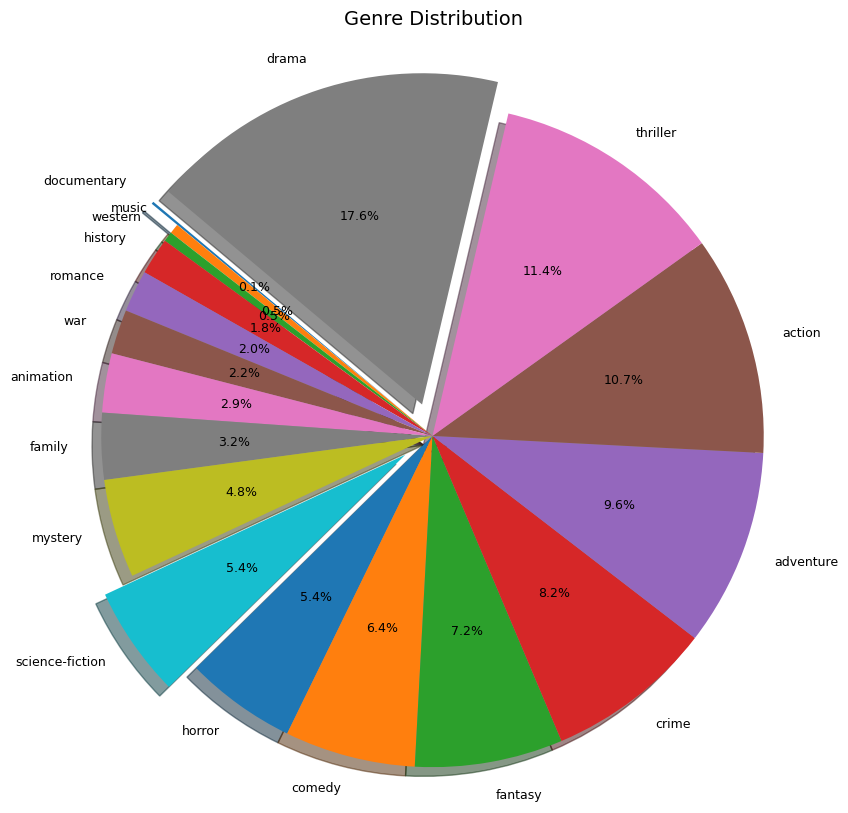

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'genre_counts' data is provided, let's create a pie chart visualization.
# Please note that we need the actual counts to generate the pie chart.
# Since the actual data is not provided, I'll create a mock-up using a hypothetical 'genre_counts' series.

# Mock genre counts similar to what the user's code would produce
# These numbers are arbitrary and for demonstration purposes only
genre_counts = pd.Series({
'drama' : 146,
'thriller': 95,
'action' : 89,
'adventure': 80,
'crime'  : 68,
'fantasy' : 60 ,
'comedy'  : 53,
'horror' :45,
'science-fiction' :45,
'mystery' :40,
'family' :27,
'animation':24,
'war'   :18,
'romance' :17,
'history' :15,
'music' :4,
'western' :4,
'documentary':1,
    # Add other genres as needed
})

# Sort genres for better visual arrangement
genre_counts_sorted = genre_counts.sort_values()

# Explode the first, middle, and last slice
explode = [0.1 if i == 0 or i == len(genre_counts_sorted) // 2 or i == len(genre_counts_sorted) - 1 else 0 
           for i in range(len(genre_counts_sorted))]

# Generate the pie chart
plt.figure(figsize=(10, 10))  # Increase figure size
plt.pie(genre_counts_sorted, labels=genre_counts_sorted.index, autopct='%1.1f%%', startangle=140,
        explode=explode, shadow=True, textprops={'fontsize': 9})

plt.title('Genre Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()


In [18]:
import pandas as pd

# Function to convert star ratings to numeric scale
def convert_stars_to_numeric(rating_stars):
    return rating_stars.count('★') + 0.5 * rating_stars.count('½')

# Apply the conversion function to the 'rating' column
unique_movies['numeric_rating'] = unique_movies['rating'].apply(convert_stars_to_numeric)

# Create dummy variables for each genre
genre_dummies = unique_movies['Genre'].str.get_dummies(sep=', ')

# Concatenate the genre dummies with the numeric ratings
data_with_dummies = pd.concat([unique_movies['numeric_rating'], genre_dummies], axis=1)

# Calculate the correlation between the genre dummies and the numeric ratings
correlation_matrix = data_with_dummies.corr()

# Extract the correlations between genres and the numeric rating
genre_correlations = correlation_matrix['numeric_rating'].drop('numeric_rating')

# Display the correlation coefficients
print(genre_correlations.sort_values(ascending=False))


drama              0.301405
adventure          0.079186
comedy             0.074335
family             0.051782
western            0.036431
crime              0.030445
history            0.004255
romance           -0.008988
war               -0.027833
horror            -0.030950
documentary       -0.044643
science-fiction   -0.049079
thriller          -0.054256
action            -0.124085
fantasy           -0.135583
animation         -0.180542
Name: numeric_rating, dtype: float64


/var/folders/mz/yljc_3wj1kd81gc90ytshcfh0000gn/T/ipykernel_49300/797262642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['numeric_rating'] = unique_movies['rating'].apply(convert_stars_to_numeric)


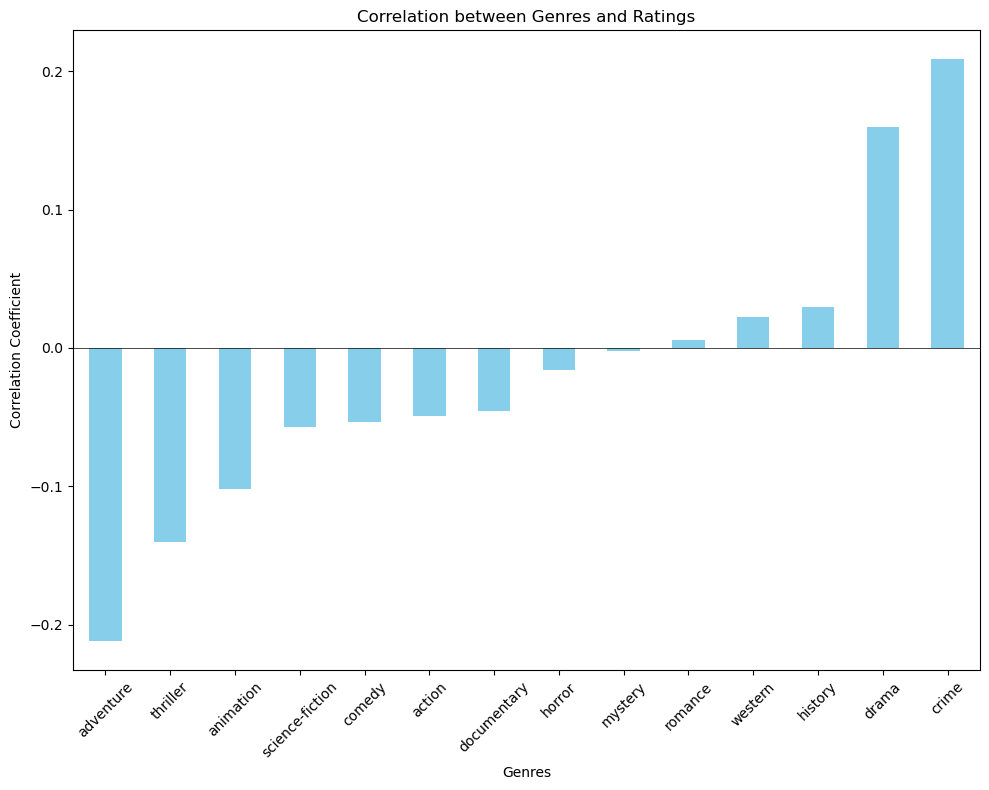

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'genre_correlations' is a Pandas Series with the index as genres and the values as correlation coefficients

genre_correlations = pd.Series({
    'crime': 0.208417,
    'drama': 0.159504,
    'history': 0.029871,
    'western': 0.022261,
    'romance': 0.005815,
    'mystery': -0.002159,
    'horror': -0.015867,
    'documentary': -0.045322,
    'action': -0.049411,
    'comedy': -0.053153,
    'science-fiction': -0.056899,
    'animation': -0.101660,
    'thriller': -0.140311,
    'adventure': -0.211655
})

# Sort the values for better visualization
genre_correlations_sorted = genre_correlations.sort_values()

# Create a bar chart for the correlation coefficients
plt.figure(figsize=(10, 8))
genre_correlations_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation between Genres and Ratings')
plt.xlabel('Genres')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()


/var/folders/mz/yljc_3wj1kd81gc90ytshcfh0000gn/T/ipykernel_49300/673225531.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['numeric_rating'] = unique_movies['rating'].apply(stars_to_numeric)


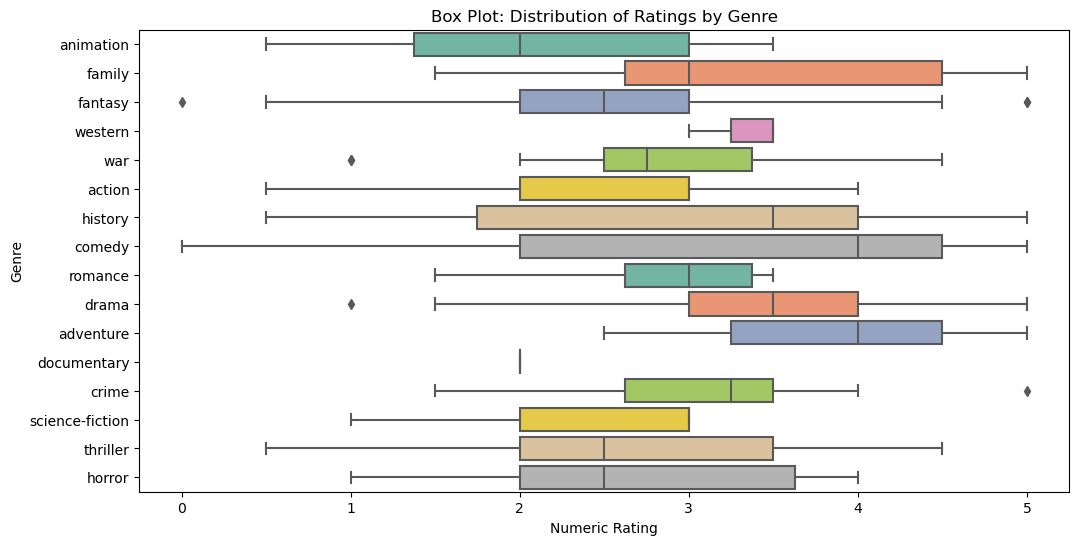

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'unique_movies' is your DataFrame with movies and ratings
# Replace 'unique_movies' with the actual variable name of your DataFrame.

# Function to convert star ratings (e.g., "★★★½") to a numeric scale
def stars_to_numeric(rating):
    full_stars = rating.count('★')
    half_star = rating.count('½') * 0.5
    return full_stars + half_star

# Convert the 'rating' column to numeric ratings
unique_movies['numeric_rating'] = unique_movies['rating'].apply(stars_to_numeric)

# Now we will calculate the average rating for each genre
# Since each movie can have multiple genres, we need to split the genres and then calculate the average rating
# We'll explode the 'Genre' column so each genre has its own row
exploded_genres = unique_movies.assign(Genre=unique_movies['Genre'].str.split(', ')).explode('Genre')

# Create a box plot to visualize the distribution of ratings by genre
plt.figure(figsize=(12, 6))  # Set the figure size

# Create a box plot using Seaborn
sns.boxplot(x='numeric_rating', y='Genre', data=exploded_genres, palette='Set2')

# Set labels and title
plt.xlabel('Numeric Rating')
plt.ylabel('Genre')
plt.title('Box Plot: Distribution of Ratings by Genre')

# Show the plot
plt.show()


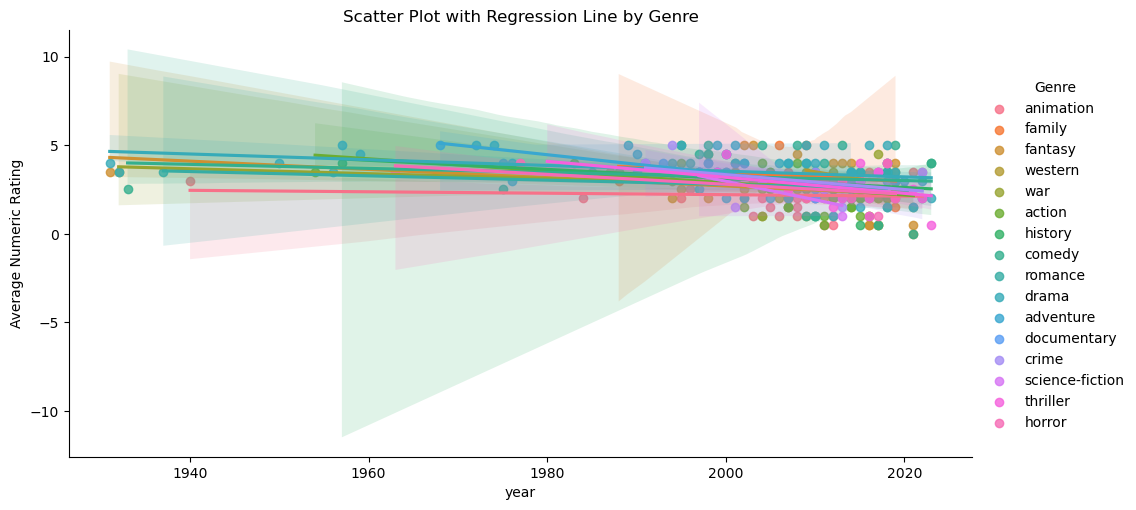

In [21]:
# Convert the 'Year' column to numeric (assuming it's stored as strings)
exploded_genres['year'] = pd.to_numeric(exploded_genres['year'], errors='coerce')

# Create the scatter plot with a regression line
sns.lmplot(x='year', y='numeric_rating', hue='Genre', data=exploded_genres, aspect=2)

# Set the title and labels
plt.title('Scatter Plot with Regression Line by Genre')
plt.xlabel('year')
plt.ylabel('Average Numeric Rating')

plt.show()


/var/folders/mz/yljc_3wj1kd81gc90ytshcfh0000gn/T/ipykernel_49300/3452619822.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['year'] = unique_movies['year'].astype(int)
/var/folders/mz/yljc_3wj1kd81gc90ytshcfh0000gn/T/ipykernel_49300/3452619822.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['numeric_rating'] = unique_movies['numeric_rating'].astype(float)


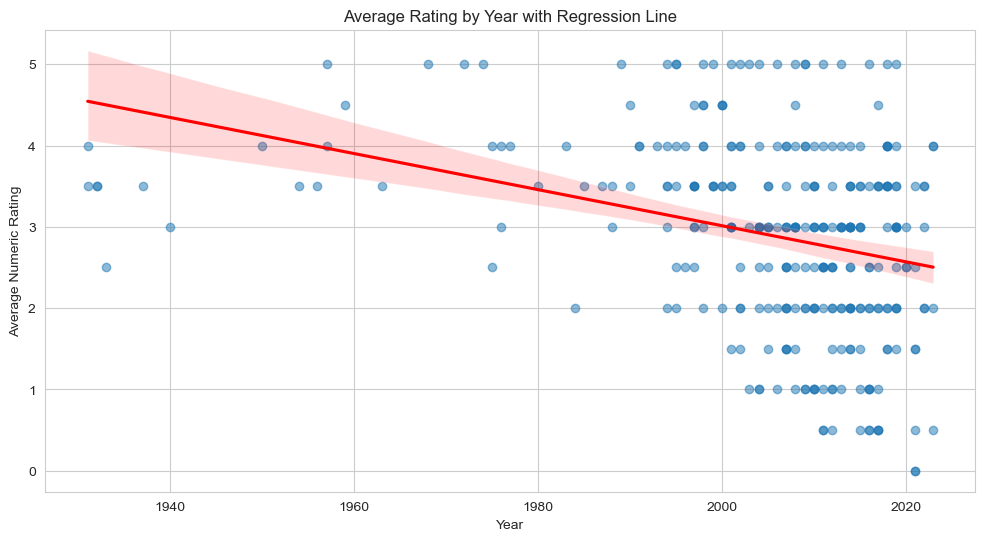

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'unique_movies' with 'year' and 'numeric_rating' columns
# Let's first ensure 'year' is an integer and 'numeric_rating' is a float
unique_movies['year'] = unique_movies['year'].astype(int)
unique_movies['numeric_rating'] = unique_movies['numeric_rating'].astype(float)

# Now we plot using seaborn
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create the scatter plot with a regression line
plt.figure(figsize=(12, 6))
sns.regplot(x='year', y='numeric_rating', data=unique_movies, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Set the title and labels
plt.title('Average Rating by Year with Regression Line')
plt.xlabel('Year')
plt.ylabel('Average Numeric Rating')

# Display the plot
plt.show()


/var/folders/mz/yljc_3wj1kd81gc90ytshcfh0000gn/T/ipykernel_49300/4026077463.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['decade'] = (unique_movies['year'] // 10 * 10).astype(str) + 's'


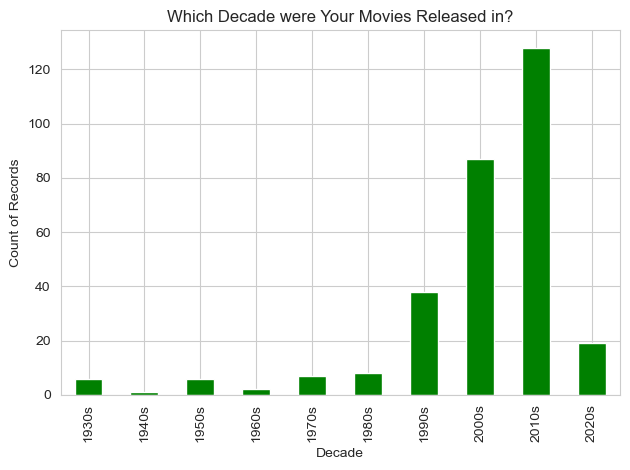

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'unique_movies' is your DataFrame and it has a 'year' column

# Convert 'year' to a string to cut off the last digit and create a 'decade' column
unique_movies['decade'] = (unique_movies['year'] // 10 * 10).astype(str) + 's'

# Count the number of movies per decade
decade_counts = unique_movies.groupby('decade').size()

# Plot the results in a bar chart
decade_counts.plot(kind='bar', color='green')

# Set the title and labels
plt.title('Which Decade were Your Movies Released in?')
plt.xlabel('Decade')
plt.ylabel('Count of Records')

# Display the plot
plt.tight_layout()  # Adjust layout
plt.show()


/var/folders/mz/yljc_3wj1kd81gc90ytshcfh0000gn/T/ipykernel_49300/3139498592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['my_numeric_rating'] = unique_movies['rating'].apply(stars_to_numeric)


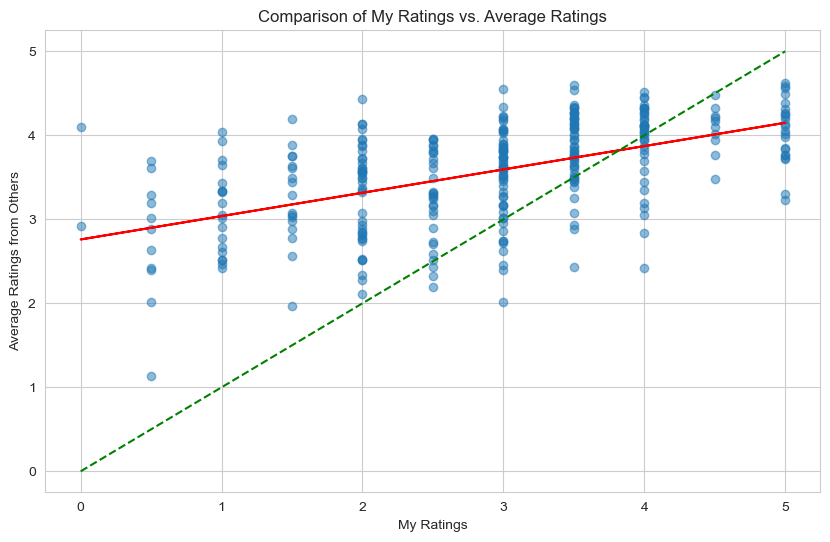

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'unique_movies' is your DataFrame

# Convert star ratings to numeric if they are in a textual format (e.g., "★★★½")
def stars_to_numeric(rating):
    if rating is not None:  # Check if the rating is not None
        full_stars = rating.count('★')
        half_star = rating.count('½') * 0.5
        return full_stars + half_star
    else:
        return np.nan  # Return NaN if the rating is None

# Apply the conversion function to your 'rating' column
unique_movies['my_numeric_rating'] = unique_movies['rating'].apply(stars_to_numeric)

# Drop rows where either 'my_numeric_rating' or 'avg_rating' is NaN
unique_movies = unique_movies.dropna(subset=['my_numeric_rating', 'avg_rating'])

# Ensure that 'avg_rating' is a float
unique_movies['avg_rating'] = unique_movies['avg_rating'].astype(float)

# Now create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(unique_movies['my_numeric_rating'], unique_movies['avg_rating'], alpha=0.5)

# Add a line of best fit
m, b = np.polyfit(unique_movies['my_numeric_rating'], unique_movies['avg_rating'], 1)
plt.plot(unique_movies['my_numeric_rating'], m*unique_movies['my_numeric_rating'] + b, color='red')

# Add a 45-degree line to indicate where your ratings match the average ratings
plt.plot([0, 5], [0, 5], color='green', linestyle='--')

# Set the title and labels
plt.title('Comparison of My Ratings vs. Average Ratings')
plt.xlabel('My Ratings')
plt.ylabel('Average Ratings from Others')
plt.grid(True)

# Show the plot
plt.show()


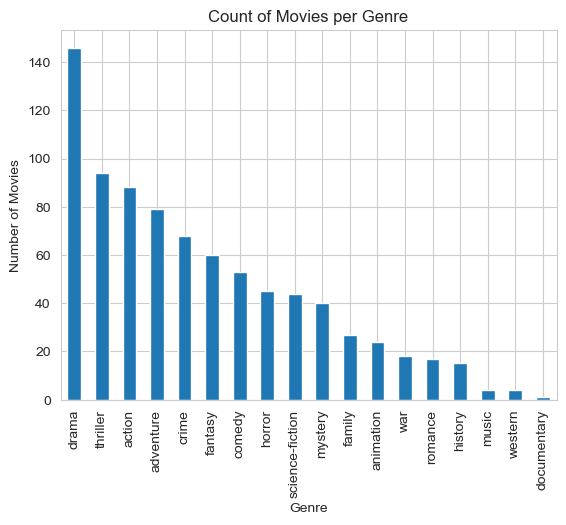

In [33]:
# This assumes that the 'Genre' column contains lists of genres that the movie belongs to
# We explode the DataFrame so each genre of a movie is a separate row
expanded_genres = all_genre_data.explode('Genre')

# Now drop duplicates based on 'id' within each genre
unique_movies_per_genre = expanded_genres.drop_duplicates(subset=['id', 'Genre'])

# Now, count the occurrences of each genre
genre_counts = unique_movies_per_genre['Genre'].value_counts()

# Plotting the counts
genre_counts.plot(kind='bar')
plt.title('Count of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()


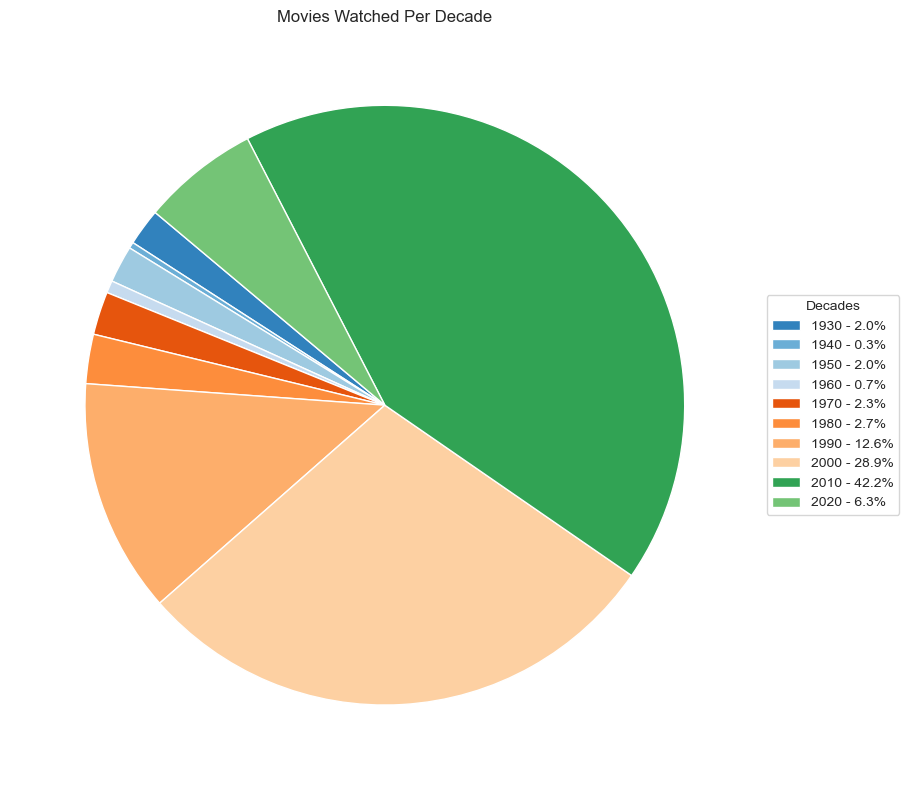

In [34]:
import matplotlib.pyplot as plt

# Assuming all_genre_data is a DataFrame with 'year' and 'decade' columns

# Count the unique number of movies in each decade
movies_per_decade = all_genre_data.groupby('decade')['id'].nunique()

# Sort the decades for a better visual arrangement
movies_per_decade.sort_index(inplace=True)

# Plotting the pie chart
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

# Generate the pie pieces
wedges, _ = ax.pie(movies_per_decade, startangle=140, colors=plt.cm.tab20c.colors)

# Add a legend outside the chart with the percentages
percentage_labels = [f'{label} - {s:1.1f}%' for label, s in zip(movies_per_decade.index, 100*movies_per_decade/movies_per_decade.sum())]
ax.legend(wedges, percentage_labels, title="Decades", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Movies Watched Per Decade')

# Adjust layout to include the legend
plt.tight_layout()

# Save the figure. Replace 'your_path_here.png' with a path on your local machine
plt.savefig('your_path_here.png', bbox_inches='tight')

plt.show()


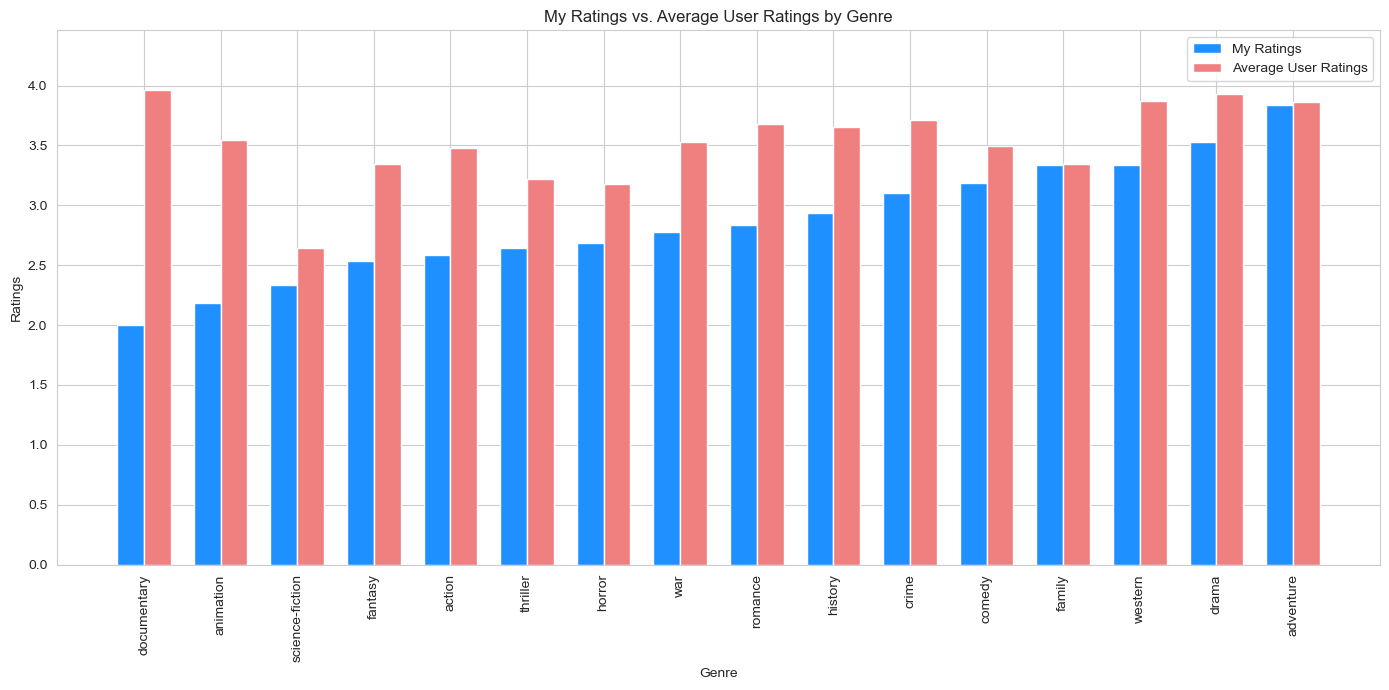

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# No need to import the DataFrame as it's already in your environment

# Convert star ratings to numeric values
def stars_to_numeric(rating):
    full_stars = rating.count('★')
    half_star = rating.count('½') * 0.5
    return full_stars + half_star

# Apply the conversion function to the 'rating' column
unique_movies['my_numeric_rating'] = unique_movies['rating'].apply(stars_to_numeric)

# Ensure 'avg_rating' is a float
unique_movies['avg_rating'] = unique_movies['avg_rating'].astype(float)

# Group by 'Genre' and calculate the average of your ratings and the average user ratings
genre_comparison = unique_movies.groupby('Genre').agg({
    'my_numeric_rating': 'mean',
    'avg_rating': 'mean'
}).reset_index()

# Sort the genres by the average of your ratings for a consistent plot order
genre_comparison.sort_values(by='my_numeric_rating', inplace=True)

# Set up the bar widths and positions
bar_width = 0.35
index = np.arange(len(genre_comparison))

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 7))
bar1 = ax.bar(index, genre_comparison['my_numeric_rating'], bar_width, label='My Ratings', color='dodgerblue')
bar2 = ax.bar(index + bar_width, genre_comparison['avg_rating'], bar_width, label='Average User Ratings', color='lightcoral')

# Set the labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Ratings')
ax.set_title('My Ratings vs. Average User Ratings by Genre')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(genre_comparison['Genre'], rotation=90)
ax.legend()

# Adjust the y-axis range to properly fit the data
ax.set_ylim(0, max(genre_comparison['my_numeric_rating'].max(), genre_comparison['avg_rating'].max()) + 0.5)

# Show the plot
plt.tight_layout()
plt.show()


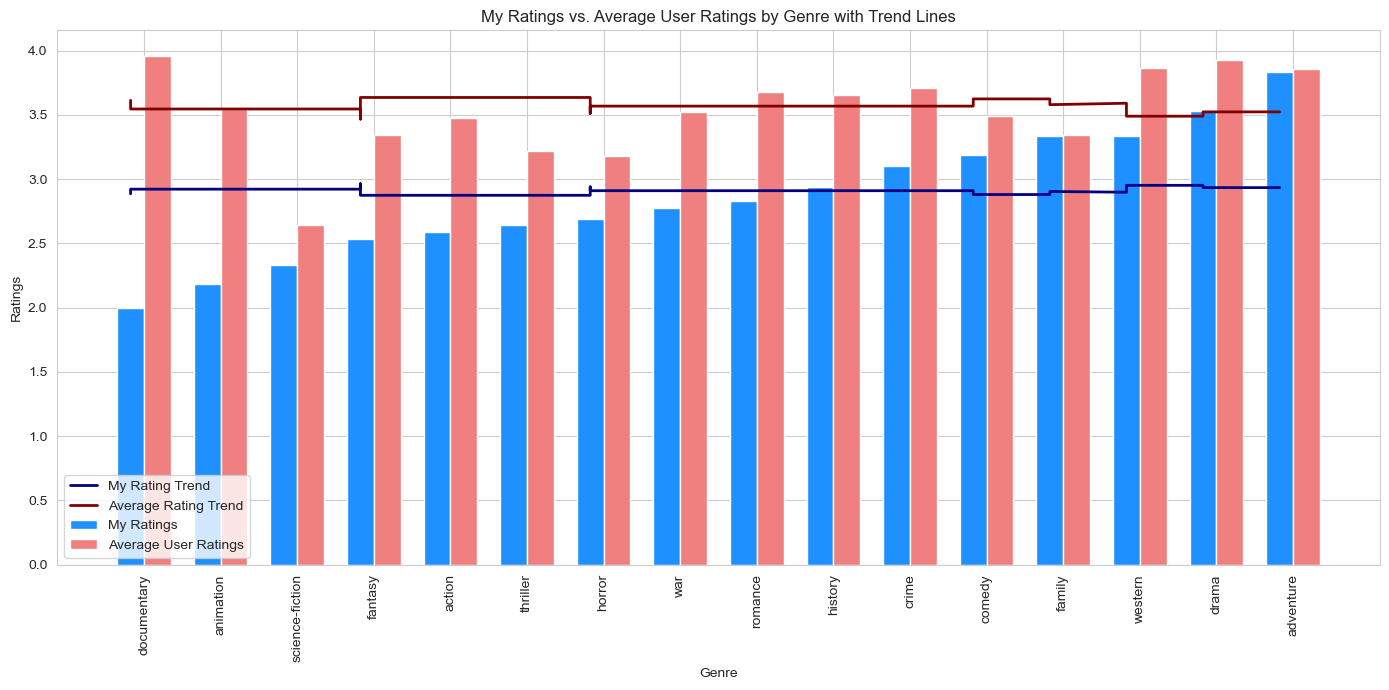

In [29]:
# Drop rows where either 'my_numeric_rating' or 'avg_rating' is NaN
unique_movies = unique_movies.dropna(subset=['my_numeric_rating', 'avg_rating'])

# Alternatively, you could fill NaN values with the mean or median
# unique_movies['my_numeric_rating'].fillna(unique_movies['my_numeric_rating'].mean(), inplace=True)
# unique_movies['avg_rating'].fillna(unique_movies['avg_rating'].mean(), inplace=True)

# Now we can create the 'genre_code' column and proceed with the regression analysis
unique_movies['genre_code'] = unique_movies['Genre'].astype('category').cat.codes

# Prepare data for regression
X = unique_movies[['genre_code']]  # Features for regression (the numeric representation of genres)
y_my_ratings = unique_movies['my_numeric_rating']  # Your ratings
y_avg_ratings = unique_movies['avg_rating']  # Average user ratings

# Create and fit the models
model_my_ratings = LinearRegression().fit(X, y_my_ratings)
model_avg_ratings = LinearRegression().fit(X, y_avg_ratings)

# Predict ratings for regression line
y_my_pred = model_my_ratings.predict(X)
y_avg_pred = model_avg_ratings.predict(X)

# Sort the genres by code for plotting
sorted_genres = unique_movies.sort_values('genre_code')

# Now create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the bar chart as before
bar_width = 0.35
index = np.arange(len(genre_comparison))
bar1 = ax.bar(index, genre_comparison['my_numeric_rating'], bar_width, label='My Ratings', color='dodgerblue')
bar2 = ax.bar(index + bar_width, genre_comparison['avg_rating'], bar_width, label='Average User Ratings', color='lightcoral')

# Add the regression lines over the bar chart
ax.plot(sorted_genres['genre_code'], y_my_pred, color='navy', linewidth=2, label='My Rating Trend')
ax.plot(sorted_genres['genre_code'], y_avg_pred, color='maroon', linewidth=2, label='Average Rating Trend')

# Add labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Ratings')
ax.set_title('My Ratings vs. Average User Ratings by Genre with Trend Lines')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(genre_comparison['Genre'], rotation=90)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [35]:
from IPython.display import display, HTML

# Assuming all_genre_data is your DataFrame with movies and their genres
for genre, group in all_genre_data.groupby('Genre'):
    display(HTML(f"<h3>{genre} Movies:</h3>"))
    display(group[['title', 'year']])


,title,year
133,"Love, Death & Robots: Bad Travelling",2022
134,Mortal Kombat,2021
135,Godzilla vs. Kong,2021
136,Birds of Prey (and the Fantabulous Emancipatio...,2020
137,Maleficent: Mistress of Evil,2019
...,...,...
217,Heat,1995
218,Léon: The Professional,1994
219,Die Hard,1988
220,Scarface,1983


,title,year
453,"Love, Death & Robots: Bad Travelling",2022
454,Mortal Kombat,2021
455,Maleficent: Mistress of Evil,2019
456,The Lion King,2019
457,Avengers: Endgame,2019
...,...,...
528,James and the Giant Peach,1996
529,Toy Story,1995
530,Jurassic Park,1993
531,Nausicaä of the Valley of the Wind,1984


,title,year
0,"Love, Death & Robots: Bad Travelling",2022
1,Save Ralph,2021
2,The Lion King,2019
3,Kung Fu Panda 3,2016
4,Hotel Transylvania,2012
5,Madagascar 3: Europe's Most Wanted,2012
6,The Smurfs,2011
7,Cars 2,2011
8,Kung Fu Panda 2,2011
9,Shrek Forever After,2010


,title,year
237,Murder Mystery 2,2023
238,Amsterdam,2022
239,Cem Yılmaz: Diamond Elite Platinum Plus,2021
240,Spree,2020
241,Murder Mystery,2019
242,Once Upon a Time… in Hollywood,2019
243,Yesterday,2019
244,Happy Death Day 2U,2019
245,BlacKkKlansman,2018
246,Game Night,2018


,title,year
534,Murder Mystery 2,2023
535,10 Days of a Good Man,2023
536,Dahmer – Monster: The Jeffrey Dahmer Story,2022
537,Amsterdam,2022
538,The Batman,2022
...,...,...
597,Scarface,1983
598,Taxi Driver,1976
599,The Godfather: Part II,1974
600,The Godfather,1972


,title,year
533,The Making of The Walking Dead,2010


,title,year
307,Society of the Snow,2023
308,10 Days of a Good Man,2023
309,Dahmer – Monster: The Jeffrey Dahmer Story,2022
310,"Love, Death & Robots: Bad Travelling",2022
311,Squid Game,2021
...,...,...
448,Gold Diggers of 1933,1933
449,The Old Dark House,1932
450,Shanghai Express,1932
451,Frankenstein,1931


,title,year
24,Maleficent: Mistress of Evil,2019
25,The Lion King,2019
26,Kung Fu Panda 3,2016
27,Hotel Transylvania,2012
28,Madagascar 3: Europe's Most Wanted,2012
29,The Smurfs,2011
30,Cars 2,2011
31,Kung Fu Panda 2,2011
32,Shrek Forever After,2010
33,Hachi: A Dog's Tale,2009


,title,year
51,"Love, Death & Robots: Bad Travelling",2022
52,Mortal Kombat,2021
53,Petite Maman,2021
54,Maleficent: Mistress of Evil,2019
55,The Lighthouse,2019
56,Yesterday,2019
57,Mandy,2018
58,Pirates of the Caribbean: Dead Men Tell No Tales,2017
59,Wonder Woman,2017
60,King Arthur: Legend of the Sword,2017


,title,year
222,Society of the Snow,2023
223,Amsterdam,2022
224,Green Book,2018
225,BlacKkKlansman,2018
226,13 Hours: The Secret Soldiers of Benghazi,2016
227,Everest,2015
228,Veda - Atatürk,2010
229,The Boy in the Striped Pyjamas,2008
230,Kingdom of Heaven,2005
231,King Arthur,2004


,title,year
746,Winnie the Pooh: Blood and Honey,2023
747,Smile,2022
748,"Love, Death & Robots: Bad Travelling",2022
749,The Conjuring: The Devil Made Me Do It,2021
750,Spree,2020
751,It Chapter Two,2019
752,Annabelle Comes Home,2019
753,Happy Death Day 2U,2019
754,The Haunting of Hill House,2018
755,The First Purge,2018


,title,year
647,Yesterday,2019
648,Bohemian Rhapsody,2018
649,A Star Is Born,2018
650,Whiplash,2014


,title,year
791,Smile,2022
792,Amsterdam,2022
793,"Love, Death & Robots: Bad Travelling",2022
794,The Batman,2022
795,Squid Game,2021
796,The Conjuring: The Devil Made Me Do It,2021
797,Annabelle Comes Home,2019
798,Murder Mystery,2019
799,The Haunting of Hill House,2018
800,Game Night,2018


,title,year
290,Yesterday,2019
291,A Star Is Born,2018
292,The Lobster,2015
293,The Theory of Everything,2014
294,The Twilight Saga: Breaking Dawn – Part 2,2012
295,The Twilight Saga: Breaking Dawn – Part 1,2011
296,The Curious Case of Benjamin Button,2008
297,Alone,2008
298,Enchanted,2007
299,A Beautiful Mind,2001


,title,year
602,Godzilla vs. Kong,2021
603,Avengers: Endgame,2019
604,Happy Death Day 2U,2019
605,Avengers: Infinity War,2018
606,War for the Planet of the Apes,2017
607,Captain America: Civil War,2016
608,The Martian,2015
610,Circle,2015
611,Mad Max: Fury Road,2015
612,Avengers: Age of Ultron,2015


,title,year
651,Winnie the Pooh: Blood and Honey,2023
652,Smile,2022
653,Amsterdam,2022
654,"Love, Death & Robots: Bad Travelling",2022
655,The Batman,2022
...,...,...
741,The Godfather: Part III,1990
742,Die Hard,1988
743,The Shining,1980
744,A Man Escaped,1956


,title,year
115,Dunkirk,2017
116,War for the Planet of the Apes,2017
117,The Mountain II,2016
118,13 Hours: The Secret Soldiers of Benghazi,2016
119,American Sniper,2014
120,Fury,2014
121,300: Rise of an Empire,2014
122,The Mountain,2012
123,Inglourious Basterds,2009
124,The Boy in the Striped Pyjamas,2008


,title,year
111,The Revenant,2015
112,Django Unchained,2012
113,Yahşi Batı,2009
114,Dead Man,1995


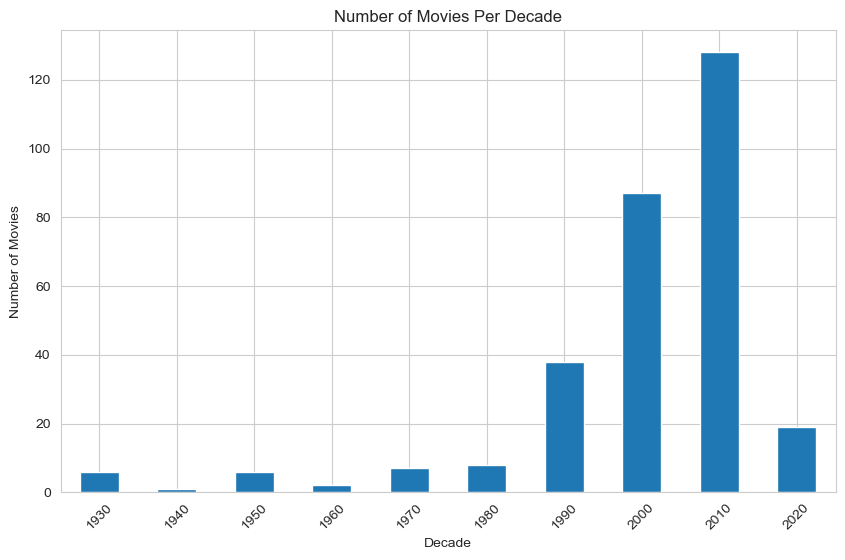

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert 'year' to integer
all_genre_data.loc[:, 'year'] = pd.to_numeric(all_genre_data['year'], errors='coerce')

# Drop rows with NaN in 'year' after conversion
all_genre_data.dropna(subset=['year'], inplace=True)
all_genre_data.loc[:, 'year'] = all_genre_data['year'].astype(int)

# Rest of your code...


# Assuming all_genre_data is your DataFrame and it includes a 'year' column
# Convert 'year' to integer
all_genre_data['year'] = pd.to_numeric(all_genre_data['year'], errors='coerce')

# Drop rows with NaN in 'year' after conversion
all_genre_data = all_genre_data.dropna(subset=['year'])
all_genre_data['year'] = all_genre_data['year'].astype(int)

# Function to categorize year into decades
def categorize_into_decade(year):
    return (year // 10) * 10

# Apply the function to create a new 'decade' column
all_genre_data['decade'] = all_genre_data['year'].apply(categorize_into_decade)

# Count the unique number of movies in each decade
movies_per_decade = all_genre_data.groupby('decade')['id'].nunique()

# Plotting
plt.figure(figsize=(10, 6))
movies_per_decade.plot(kind='bar')
plt.title('Number of Movies Per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


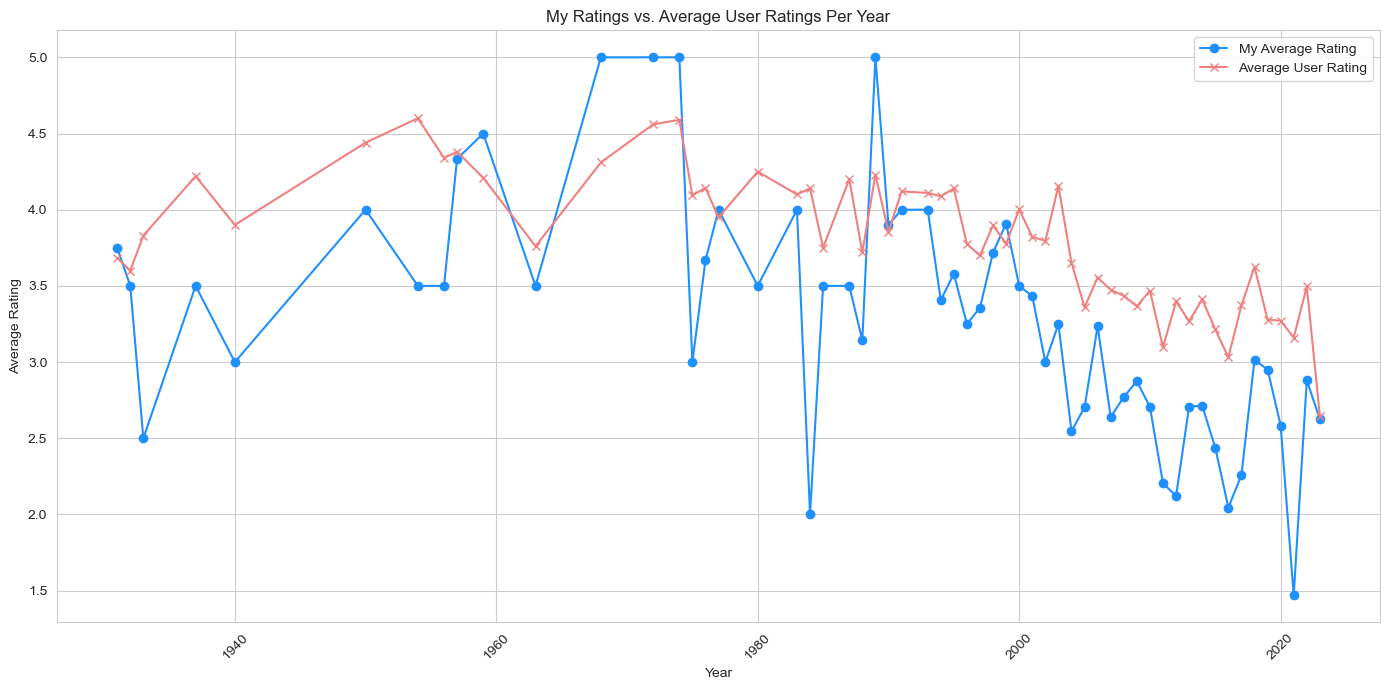

In [31]:
# Convert star ratings to numeric values
def stars_to_numeric(rating):
    full_stars = rating.count('★')
    half_star = rating.count('½') * 0.5
    return full_stars + half_star

# Apply the conversion function to the 'rating' column to create 'my_numeric_rating' column
all_genre_data['my_numeric_rating'] = all_genre_data['rating'].apply(stars_to_numeric)

# Ensure 'year' is an integer and 'avg_rating' is numeric
all_genre_data['year'] = pd.to_numeric(all_genre_data['year'], errors='coerce')
all_genre_data['avg_rating'] = pd.to_numeric(all_genre_data['avg_rating'], errors='coerce')

# Drop any NaN values that may have resulted from the conversion
all_genre_data.dropna(subset=['year', 'my_numeric_rating', 'avg_rating'], inplace=True)

# Convert year to an integer type
all_genre_data['year'] = all_genre_data['year'].astype(int)

# Group by year and calculate the average of your ratings and the average user ratings
yearly_ratings_comparison = all_genre_data.groupby('year').agg({
    'my_numeric_rating': 'mean',
    'avg_rating': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))

# Plot your average ratings per year
plt.plot(yearly_ratings_comparison['year'], yearly_ratings_comparison['my_numeric_rating'], label='My Average Rating', marker='o', color='dodgerblue')

# Plot the average user ratings per year
plt.plot(yearly_ratings_comparison['year'], yearly_ratings_comparison['avg_rating'], label='Average User Rating', marker='x', color='lightcoral')

# Set the title and labels
plt.title('My Ratings vs. Average User Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()


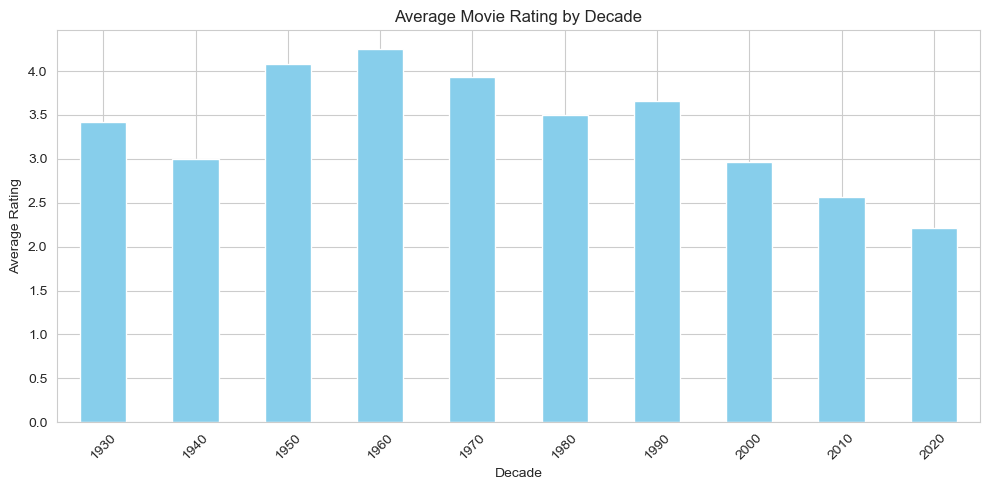

My favorite decade in terms of movies is the 1960's


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'unique_movies' is your DataFrame

# Convert star ratings to numeric values
def stars_to_numeric(rating):
    full_stars = rating.count('★')
    half_star = rating.count('½') * 0.5
    return full_stars + half_star

unique_movies['my_numeric_rating'] = unique_movies['rating'].apply(stars_to_numeric)

# Ensure the 'year' column is of integer type
unique_movies['year'] = unique_movies['year'].astype(int)

# Categorize each movie into a decade
unique_movies['decade'] = (unique_movies['year'] // 10) * 10

# Calculate the average rating you gave to movies in each decade
average_rating_by_decade = unique_movies.groupby('decade')['my_numeric_rating'].mean()

# Plot this data
plt.figure(figsize=(10, 5))
average_rating_by_decade.plot(kind='bar', color='skyblue')
plt.title('Average Movie Rating by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify which decade had the highest average rating
favorite_decade = average_rating_by_decade.idxmax()

print(f"My favorite decade in terms of movies is the {favorite_decade}'s")
